Reference: https://www.tensorflow.org/tutorials/text/text_classification_rnn  
チュートリアル：RNN を使ったテキスト分類をやってみる

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

In [3]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_examples, test_examples = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteKBII9G/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteKBII9G/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteKBII9G/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [4]:
encoder = info.features['text'].encoder

In [5]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [6]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [7]:
assert original_string == sample_string

In [8]:
for index in encoded_string:
    print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [9]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [10]:
# train_dataset = (train_examples.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=([None], [])))
# test_dataset  = (test_examples.padded_batch(BATCH_SIZE, padded_shapes=([None], [])))
train_dataset = (train_examples.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE))
test_dataset = (test_examples.padded_batch(BATCH_SIZE))

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [12]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [13]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 45s 116ms/step - loss: 0.6736 - accuracy: 0.5163 - val_loss: 0.5257 - val_accuracy: 0.7766
Epoch 2/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3599 - accuracy: 0.8475 - val_loss: 0.3464 - val_accuracy: 0.8500
Epoch 3/10
391/391 [==============================] - 47s 119ms/step - loss: 0.2575 - accuracy: 0.8998 - val_loss: 0.3207 - val_accuracy: 0.8667
Epoch 4/10
391/391 [==============================] - 47s 119ms/step - loss: 0.2169 - accuracy: 0.9204 - val_loss: 0.3693 - val_accuracy: 0.8198
Epoch 5/10
391/391 [==============================] - 47s 119ms/step - loss: 0.1889 - accuracy: 0.9314 - val_loss: 0.3407 - val_accuracy: 0.8682
Epoch 6/10
391/391 [==============================] - 47s 121ms/step - loss: 0.1657 - accuracy: 0.9420 - val_loss: 0.4161 - val_accuracy: 0.8703
Epoch 7/10
391/391 [==============================] - 47s 121ms/step - loss: 0.1503 - accuracy: 0.9486 - val_loss: 0.3590 - val_ac

In [14]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 20s 52ms/step - loss: 0.4582 - accuracy: 0.8519
Test Loss: 0.45823368430137634
Test Accuracy: 0.8519200086593628


In [15]:
def pad_to_size(vec, size):
    zeros = [0] * (size - len(vec))
    vec.extend(zeros)
    return vec

In [16]:
def sample_predict(sample_pred_text, pad):
    encoded_sample_pred_text = encoder.encode(sample_pred_text)

    if pad:
        encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)

    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
    predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

    return (predictions)

In [17]:
# パディングなしのサンプルテキストの推論

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-0.34756315]]


In [18]:
# パディングありのサンプルテキストの推論

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-0.43283245]]


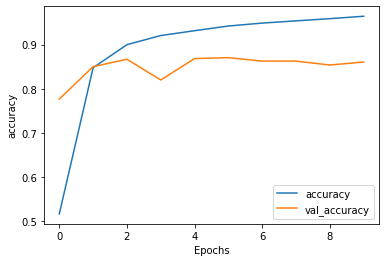

In [19]:
plot_graphs(history, 'accuracy')

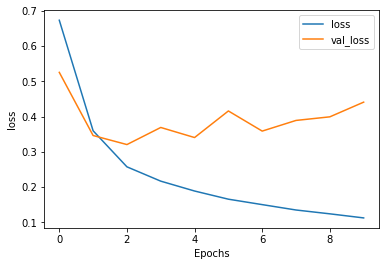

In [20]:
plot_graphs(history, 'loss')

### 2つ以上の LSTM レイヤーを重ねる

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 80s 206ms/step - loss: 0.6548 - accuracy: 0.5598 - val_loss: 0.4989 - val_accuracy: 0.7698
Epoch 2/10
391/391 [==============================] - 81s 207ms/step - loss: 0.3734 - accuracy: 0.8473 - val_loss: 0.3791 - val_accuracy: 0.8438
Epoch 3/10
391/391 [==============================] - 80s 206ms/step - loss: 0.2675 - accuracy: 0.9013 - val_loss: 0.3882 - val_accuracy: 0.8224
Epoch 4/10
391/391 [==============================] - 81s 208ms/step - loss: 0.2212 - accuracy: 0.9225 - val_loss: 0.3757 - val_accuracy: 0.8547
Epoch 5/10
391/391 [==============================] - 82s 210ms/step - loss: 0.1874 - accuracy: 0.9371 - val_loss: 0.3720 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 82s 210ms/step - loss: 0.1632 - accuracy: 0.9484 - val_loss: 0.4312 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 81s 208ms/step - loss: 0.1409 - accuracy: 0.9578 - val_loss: 0.4649 - val_ac

In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 38s 97ms/step - loss: 0.5096 - accuracy: 0.8571
Test Loss: 0.5096418261528015
Test Accuracy: 0.8570799827575684


In [25]:
# パディングなしのサンプルテキストの推論

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-3.4617991]]


In [26]:
# パディングありのサンプルテキストの推論

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-4.454009]]


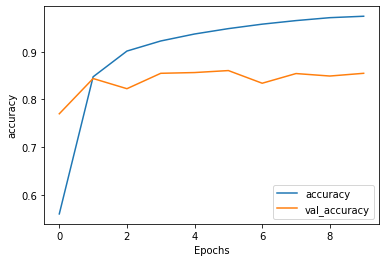

In [27]:
plot_graphs(history, 'accuracy')

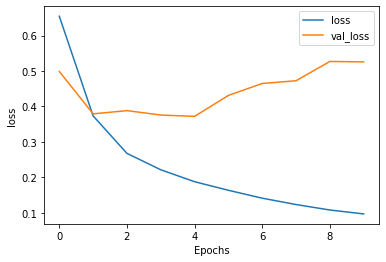

In [28]:
plot_graphs(history, 'loss')